# Preprocess Raw Data to be ready to Train

## Purpose

This notebook has the purpose to prepare the dataset to be ready use for the Deep Neural Networks Architecture that will be use for classify and compare with the paper PerceptSent.

## Import Libraries

In [16]:
import os
import shutil
import pandas as pd
import nltk
import gensim
from tqdm.notebook import tqdm
# Deep learning packages
import torch
from sklearn.model_selection import train_test_split

from collections import Counter
# from textaugment import Word2vec
# from textaugment import Fasttext
# from textaugment import Wordnet
# from textaugment import Translate
# from textaugment import Word2vec, Fasttext
# from textaugment import Translate

# Visualization packages
import matplotlib.pyplot as plt
import seaborn

In [17]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/neemias/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/neemias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/neemias/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Load DataFrame

In [19]:
!ls ..

checkpoints  experiments  notebooks  reports  scripts	   utils
data	     models	  README.md  run.sh   textaugment


In [40]:
# df = pd.read_csv("../data/raw/image_caption_mini_GPT4.csv") # captioning data for miniGPT-4
# df = pd.read_csv("../data/raw/image_caption_blip.csv") # captioning data for Blip Large model
df = pd.read_csv("../data/raw/image_caption_minigpt4_completed.csv") # captioning data for miniGPT-4
df.head()

,id,url,caption
0,1BhIkrf3HWatQFG7KxJK7MZ1oWbUczaar,https://drive.google.com/uc?export=view&id=1px...,The image shows a group of people standing on ...
1,15LVGeXllPyPe1jicnPTPl6kbBYJ5lZh8,https://drive.google.com/uc?export=view&id=1Ym...,This image shows the inside of a wooden attic ...
2,17dUXoyKzr4fS9QF-y3HU2oscLMvA9qLd,https://drive.google.com/uc?export=view&id=1pT...,The image shows a red mailbox sitting on the s...
3,11_yZVpq48fA-jchrZO_sTtUKQejXd-te,https://drive.google.com/uc?export=view&id=1Ik...,The image shows a black car with a broken wind...
4,1jH7ZVa_ZAbqNTheP2gTN5WOLI_NwkPwZ,https://drive.google.com/uc?export=view&id=17E...,The image shows a woman standing on the sidewa...


In [41]:
# df["id"] = df["image_path"].apply(lambda x: x.split('/')[-1].split('.')[0]) # for miniGPT4

In [42]:
df.shape

(4999, 3)

In [43]:
df.head()

,id,url,caption
0,1BhIkrf3HWatQFG7KxJK7MZ1oWbUczaar,https://drive.google.com/uc?export=view&id=1px...,The image shows a group of people standing on ...
1,15LVGeXllPyPe1jicnPTPl6kbBYJ5lZh8,https://drive.google.com/uc?export=view&id=1Ym...,This image shows the inside of a wooden attic ...
2,17dUXoyKzr4fS9QF-y3HU2oscLMvA9qLd,https://drive.google.com/uc?export=view&id=1pT...,The image shows a red mailbox sitting on the s...
3,11_yZVpq48fA-jchrZO_sTtUKQejXd-te,https://drive.google.com/uc?export=view&id=1Ik...,The image shows a black car with a broken wind...
4,1jH7ZVa_ZAbqNTheP2gTN5WOLI_NwkPwZ,https://drive.google.com/uc?export=view&id=17E...,The image shows a woman standing on the sidewa...


In [44]:
# df["caption"] = df["caption"].apply(lambda x: x.replace("The image shows", '').replace("This is", '').replace("This image", '').replace("The image", '').replace("\u200b", '').replace("\n", ' ').replace("<Img>", ''))

In [45]:
# model = gensim.models.KeyedVectors.load_word2vec_format('../models/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [46]:
import json

f = open("../data/raw/dataset.json")
 
# returns JSON object as 
# a dictionary
data = json.load(f)

f.close()

In [47]:
sentiment_dict = {
    "SlightlyNegative": "Negative",
    # "SlightlyNegative": "SlightlyNegative",
    "SlightlyPositive": "Positive",
    # "SlightlyPositive": "SlightlyPositive",
    "Neutral": "Neutral",
    "Positive": "Positive",
    "Negative": "Negative"
}

In [48]:
def ia_calculation(sg):
    """
    Calcula a métrica IA (Image Agreement) com base no vetor de sentimento agrupado (sg).

    Parâmetros:
    sg (list ou tuple): Vetor de sentimento agrupado, onde cada elemento representa o número de votos para uma categoria de sentimento.

    Retorna:
    float: A métrica IA.
    """
    total_avaliadores = len(sg)
    max_votos = max(sg)
    IA = max_votos / total_avaliadores
    return IA

sentiment_data = {}

for id, caption in tqdm(zip(df["id"], df["caption"]), total=len(df), desc="Create supervised dataset"):
    sentiment_data[id] = {
        "sparse sentiment": [],
        "cluster sentiment": [],
        "perceptions": [],
        "caption": caption,
        "image_agreement": float,
    }

simple_sentiment = {
    "Positive": "Positive",
    "SlightlyPositive": "Positive",
    # "SlightlyPositive": "SlightlyPositive",
    "Neutral": "Neutral",
    "SlightlyNegative": "Negative",
    # "SlightlyNegative": "SlightlyNegative",
    "Negative": "Negative"
}
# sentiment_idx = {
#     "Positive": 4,
#     "SlightlyPositive": 3,
#     "Neutral": 2,
#     "SlightlyNegative": 1,
#     "Negative": 0
# }
sentiment_idx = {
    "Positive": 2,
    "Neutral": 1,
    "Negative": 0
}


for samples in tqdm(data["tasks"], desc="Image perceptions"):
    for sample in samples["images"]:
        id = sample["id"]
        sentiment = sample["sentiment"]
        # perceptions = ', '.join([str(per) for per in sample["perceptions"]])
        perceptions = [str(per) for per in sample["perceptions"]]
        
        if id in sentiment_data:
            # sentiment = [simple_sentiment[sent] for sent in sentiment]
            sentiment_data[id]["sparse sentiment"].append(sentiment)
            sentiment_data[id]["cluster sentiment"].append(simple_sentiment[sentiment])
            for perception in perceptions:
                sentiment_data[id]["perceptions"].append(perception)

for id in tqdm(sentiment_data, desc="Image agreement calculation"):
    sentiment = sentiment_data[id]["sparse sentiment"]
    sg = [0 for _ in range(len(sentiment))]
    counter = Counter(sentiment)
    for key in counter:
        sg[sentiment_idx[key]] = counter[key]
    sentiment_data[id]["image_agreement"] = ia_calculation(sg)

Create supervised dataset:   0%|          | 0/4999 [00:00<?, ?it/s]

Image perceptions:   0%|          | 0/2500 [00:00<?, ?it/s]

Image agreement calculation:   0%|          | 0/4999 [00:00<?, ?it/s]

KeyError: 'SlightlyNegative'

In [49]:
import warnings
warnings.filterwarnings("ignore")
data = {
    "text": [],
    "target": [],
}

# sentiment_values = {
#     "Negative": 0,
#     "SlightlyNegative": 1,
#     "Neutral": 2,
#     "SlightlyPositive": 3,
#     "Positive": 4,
# }
sentiment_values = {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 1,
}

for id in tqdm(sentiment_data, desc="Zero-shot-classification progress"):
    caption = sentiment_data[id]["caption"]
    sentiment = list(sentiment_data[id]["cluster sentiment"])
    unique_perceptions = list(set(sentiment_data[id]["perceptions"]))
    # max_value = result[pred]
    ia = sentiment_data[id]["image_agreement"]    

    label = Counter(sentiment)
    counter = Counter(sentiment)
    # print(sentiment)
    # print(label)
    # print(counter)
    most_common_sentiment, frequency = counter.most_common(1)[0]
    if (frequency >= 4): # 3 -> alpha3; 4 -> alpha4; 5 -> alpha5
        data["text"].append(caption)
        data["target"].append(sentiment_values[most_common_sentiment])

Zero-shot-classification progress:   0%|          | 0/4999 [00:00<?, ?it/s]

In [50]:
data["text"][0], data["target"][0]

('The image shows a group of people standing on the sidewalk in front of a building. They are all wearing masks to protect themselves from the smoke in the air. The building in the background appears to be a church, with a cross on top of it. The sky is hazy and there is a lot of smoke in the air. The people in the image are standing in a line, with some of them looking at their phones or talking to each other. There is a car parked on the side of the road, and some trees can be seen in the background.',
 0)

## Analyze the Target Distribution

In [51]:
def plot_sentiment_distribution(df):
    """"
    Plots the distribution of sentiments
    Parameters:
        df(dataframe): DataFrame containing the "sentiment" column.

    Returns:
        None
    """

    mapping = {0: "Negative", 1: "Positive"}
    # mapping = {1: "Negative", 0: "Neutral", 2: "Positive"}
    # mapping = {0: "Negative", 1: "SlightlyNegative", 2: "Neutral", 3: "SlightlyPositive", 4: "Positive"}
    df["sentiment"] = df["sentiment"].map(mapping)
    sentiment_counts = df["sentiment"].value_counts()

    plt.figure(figsize=(6, 4))
    sentiment_counts.plot(kind="bar", color="skyblue")
    plt.title("Sentiment Distribution")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

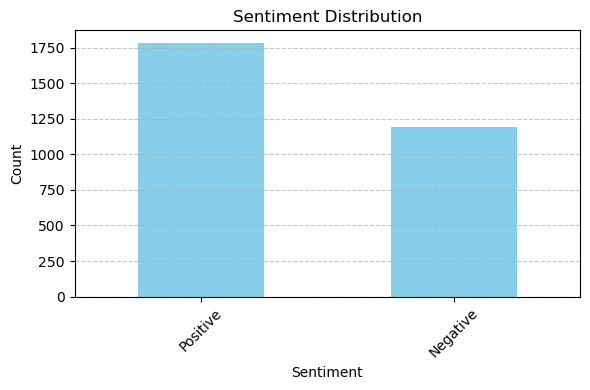

In [52]:
plot_sentiment_distribution(pd.DataFrame({"sentiment": data["target"]}))

In [53]:
data["text"][:5], data["target"][:5]

(['The image shows a group of people standing on the sidewalk in front of a building. They are all wearing masks to protect themselves from the smoke in the air. The building in the background appears to be a church, with a cross on top of it. The sky is hazy and there is a lot of smoke in the air. The people in the image are standing in a line, with some of them looking at their phones or talking to each other. There is a car parked on the side of the road, and some trees can be seen in the background.',
  'This image shows the inside of a wooden attic with wooden beams and a wooden floor. The walls are made of wooden planks and there are no windows or doors visible. There is a wooden staircase leading up to the attic. The lighting is dim and the atmosphere is quiet and peaceful.',
  'The image shows a black car with a broken windshield on the side of the road. The car is parked on the side of the road and there is a man standing next to it with a hammer in his hand. The man is wearin

In [54]:
len(data["target"])

2977

## Train & Test Split

## Save DataFrames

In [55]:
# train_df.to_csv("../data/train/train.csv", index=False)
# # aug_train_df.to_csv("../data/train/aug_train.csv", index=False)
# val_df.to_csv("../data/validation/val.csv", index=False)
# test_df.to_csv("../data/test/test.csv", index=False)

In [51]:
# pd.DataFrame({"text": data["text"], "sentiment": data["target"]}).to_csv("../data/percept_dataset_alpha3_p5.csv", index=False)
# pd.DataFrame({"text": data["text"], "sentiment": data["target"]}).to_csv("../data/percept_dataset_alpha3_p3.csv", index=False)
# pd.DataFrame({"text": data["text"], "sentiment": data["target"]}).to_csv("../data/percept_dataset_alpha3_p2plus.csv", index=False)
# pd.DataFrame({"text": data["text"], "sentiment": data["target"]}).to_csv("../data/percept_dataset_alpha3_p2neg.csv", index=False)

In [55]:
# pd.DataFrame({"text": data["text"], "sentiment": data["target"]}).to_csv("../data/percept_dataset_alpha4_p5.csv", index=False)
# pd.DataFrame({"text": data["text"], "sentiment": data["target"]}).to_csv("../data/percept_dataset_alpha4_p3.csv", index=False)
pd.DataFrame({"text": data["text"], "sentiment": data["target"]}).to_csv("../data/percept_dataset_alpha4_p2plus.csv", index=False)
# pd.DataFrame({"text": data["text"], "sentiment": data["target"]}).to_csv("../data/percept_dataset_alpha4_p2neg.csv", index=False)